In [1]:
import tensorflow as tf

C:\Users\a0970\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
#取1000筆資料訓練就好
test1,test2=mnist.test.next_batch(1000)

In [9]:
print(test1.shape)
print(test2.shape)

(1000, 784)
(1000, 10)


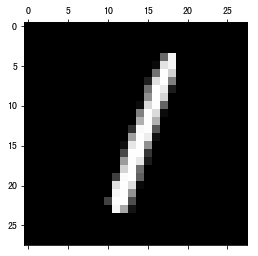

In [50]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
first_train_img = np.reshape(test1[0], (28, 28))
plt.matshow(first_train_img, cmap = plt.get_cmap('gray'))
plt.savefig('mnist_1')
plt.show()

In [10]:
#定義CNN的參數
learning_rate=0.001
training_iters=100000
batch_size=128
display_step=10

In [11]:
#每個形狀為28*28的像素
n_input=784

In [12]:
#答案為0~9
n_classes=10

In [13]:
#為了減少過度配飾,我們使用dropout來丟棄單元
dropout=0.75

In [14]:
#為輸入圖形定義placeholder 
x=tf.placeholder(tf.float32,[None,n_input])

In [16]:
#用reshape將4D輸入資料改成張量(這裡仍需理解)
#2,3維為寬度和高度,第四維為顏色的總數
_X=tf.reshape(x,shape=[-1,28,28,1])

In [17]:
y= tf.placeholder(tf.float32,[None,n_classes])

In [21]:
#卷基層的每一個神經元連接到維度大小為5*5的輸入張量,因此隱藏層的大小為28+1-5=24
#wcl為共享權重,bcl為共享偏差
#32代表我們設定了32個特徵圖譜
wc1= tf.Variable(tf.random_normal([5,5,1,32]))
bc1= tf.Variable(tf.random_normal([32]))

In [20]:
#建構卷基層
#激活層使用relu
#strides設定為1
#padding='SAME',會使用zero-padding策略,讓圖不受到kernal map大小影響
#padding="VALID",不使用zero-padding,圖的大小會因為kernal map 受影響 
def conv2d(img,w,b):
    return tf.nn.relu(tf.nn.bias_add\
                     (tf.nn.conv2d(img,w,\
                                  strides=[1,1,1,1],
                                  padding='SAME'),b))

In [22]:
#第一層
conv1= conv2d(_X,wc1,bc1)

In [24]:
#池化層建構
#池化策略選擇max_pooling
#池化的目標是將資料再度壓縮,會將資料壓縮成k*k
#
def max_pool(img,k):
    return tf.nn.max_pool(img,
                         ksize=[1,k,k,1],
                         strides=[1,k,k,1],
                         padding='SAME')


In [25]:
#池化層建構
conv1=max_pool(conv1,k=2)


In [26]:
#最後一層進行dropout處理
keep_prob=tf.placeholder(tf.float32)
conv1= tf.nn.dropout(conv1,keep_prob)

至此conv1就是我們第一層的輸出了,cnn就是一層一層的把CNN架起來

In [28]:
#第二卷積層
#第二隱藏層將具有5*5窗口的64個特徵,輸入層的數量將來自第一卷積層.我們對32個conv1層,應用64組5*5的過濾器
wc2=tf.Variable(tf.random_normal([5,5,32,64]))
bc2=tf.Variable(tf.random_normal([64]))

In [29]:
#重複在conv1的操作
conv2= conv2d(conv1,wc2,bc2)
conv2=max_pool(conv2,k=2)
conv2=tf.nn.dropout(conv2, keep_prob)

In [30]:
#建立全連接層
#1024個神經元
wd1=tf.Variable(tf.random_normal([7*7*64,1024]))
bd1=tf.Variable(tf.random_normal([1024]))

#將張量從第二卷積層(7*7*64)重塑成一個向量
#flattern
dense1= tf.reshape(conv2,[-1,wd1.get_shape().as_list()[0]])
#dense1*wd1+bd1
dense1= tf.nn.relu(tf.add(tf.matmul(dense1,wd1),bd1))

dense1=tf.nn.dropout(dense1,keep_prob)


In [31]:
#output層
wout= tf.Variable(tf.random_normal([1024,n_classes]))
bout= tf.Variable(tf.random_normal([n_classes]))

In [32]:
pred= tf.add(tf.matmul(dense1,wout),bout)

In [38]:
#預測模型
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))

In [39]:
#最佳化
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [40]:
#用於評估階段
correct_pred=tf.equal(tf.argmax(pred,1),(tf.argmax(y,1)))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [41]:
#啟動session
init= tf.global_variables_initializer()

In [45]:
with tf.Session() as sess:
    #initialize
    sess.run(init)
    step=1
    #keep training until reach max iteration
    while step*batch_size <training_iters:
        batch_xs,batch_ys= mnist.train.next_batch(batch_size)
        sess.run(optimizer,feed_dict={x:batch_xs,
                                     y:batch_ys,
                                     keep_prob:dropout})
        if step% display_step==0:
            #calculate batch accuracy
            acc= sess.run(accuracy,feed_dict={x:batch_xs,
                                             y:batch_ys,
                                             keep_prob:1.0})
            loss=sess.run(cost,feed_dict={x:batch_xs,
                                         y:batch_ys,
                                         keep_prob:1.0})
            print("iter "+str(step*batch_size)+"  Minibatch_loss="+"{:.6f}".format(loss)+", Training Accuracy="+"{:.5f}".format(acc))
        step+=1
    print("optimization Finished!")
    print('Testing Accuracy:',sess.run(accuracy,feed_dict={x:mnist.test.images[:256],
                                                          y:mnist.test.labels[:256],
                                                          keep_prob:1.0}))

iter 1280  Minibatch_loss=24987.375000, Training Accuracy=0.17188
iter 2560  Minibatch_loss=14644.159180, Training Accuracy=0.26562
iter 3840  Minibatch_loss=9725.971680, Training Accuracy=0.51562
iter 5120  Minibatch_loss=6126.162109, Training Accuracy=0.63281
iter 6400  Minibatch_loss=5366.147461, Training Accuracy=0.63281
iter 7680  Minibatch_loss=4399.464844, Training Accuracy=0.75000
iter 8960  Minibatch_loss=3434.971436, Training Accuracy=0.78906
iter 10240  Minibatch_loss=3860.717773, Training Accuracy=0.72656
iter 11520  Minibatch_loss=4963.845215, Training Accuracy=0.77344
iter 12800  Minibatch_loss=3639.841553, Training Accuracy=0.82031
iter 14080  Minibatch_loss=2232.244629, Training Accuracy=0.78125
iter 15360  Minibatch_loss=2262.990479, Training Accuracy=0.81250
iter 16640  Minibatch_loss=2589.622559, Training Accuracy=0.82812
iter 17920  Minibatch_loss=2392.213379, Training Accuracy=0.82812
iter 19200  Minibatch_loss=2917.047119, Training Accuracy=0.79688
iter 20480  Min